# Random Acts of Pizza (RAOP) Notes


In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import os
import codecs
import json
import csv

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tseries.holiday import USFederalHolidayCalendar

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/Maximus/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:42: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.19.
  "This module will be removed in 0.19.", DeprecationWarning)
/Users/Maximus/anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.19.
  DeprecationWarning)


# Data Exploration

In [2]:
X = pd.read_json('./pizza_request_dataset.json')

# set random seed
np.random.seed(0)

# randomly assign 70% to train_data, and 30% to dev_data
msk = np.random.rand(len(X)) <= 0.7
train_data = X[msk]
dev_data = X[~msk]

# create output dataframe Y of train_labels
train_labels = train_data[["requester_received_pizza"]]

# delete train_labels from input dataframe of train_data
del train_data["requester_received_pizza"]

# create output dataframe of dev_labels
dev_labels = dev_data[["requester_received_pizza"]]

# delete dev_labels from input dataframe of dev_data
del dev_data["requester_received_pizza"]


In [3]:
# prepare data
# transform X to numpy array, and Y to 1-D numpy array
# view actual text and labels

train_text = train_data["request_text"]
dev_text = dev_data["request_text"]

print ("type(train_text)", type(train_text))
print ("type(train_labels)", type(train_labels))
print ("type(dev_text)", type(dev_text))
print ("type(dev_labels)", type(dev_labels)), "/n"


def to_np(d):

    d = np.array(d)
    d = d.flatten()

    return d

train_text = to_np(train_text)
train_labels = to_np(train_labels)
dev_text = to_np(dev_text)
dev_labels = to_np(dev_labels)

# convert to list

def to_list(d):

    #print ("list:")
    d = list(d)
    return d


print ("train_labels.shape:", train_labels.shape)
print ("dev_labels.shape:", dev_labels.shape)

('type(train_text)', <class 'pandas.core.series.Series'>)
('type(train_labels)', <class 'pandas.core.frame.DataFrame'>)
('type(dev_text)', <class 'pandas.core.series.Series'>)
('type(dev_labels)', <class 'pandas.core.frame.DataFrame'>) /n
('train_labels.shape:', (3975,))
('dev_labels.shape:', (1696,))


# Model Exploration

In [15]:
import operator

# Notes
# Classifier precision--when a positive value is predicted, proportion of time the prediction is correct--equals (TP) / (TP + FP)
# Classifier recall--when the actual value is positive, the proportion of time the prediction is correct--equals (TP) / (TP + FN)

def explore_models():

    # create empty vector
    accuracies = []

    # Source: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
    # The F1 score can be interpreted as a weighted average of the precision and recall, 
    # where an F1 score reaches its best value at 1 and worst score at 0. 
    # The relative contribution of precision and recall to the F1 score are equal. 
    # The formula for the F1 score is: F1 = 2 * (precision * recall) / (precision + recall)
    
    vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
    #vectorizer = CountVectorizer(min_df=1, stop_words='english')
    train_vectors = vectorizer.fit_transform(train_text)
    print ("train_vectors.shape:", train_vectors.shape)
    
    dev_vectors = vectorizer.transform(dev_text)
    print ("dev_vectors.shape:", dev_vectors.shape)
    print
    
    #------------------------
    # K Nearest Neighbors
    #------------------------
    
    print ("------------------------------")
    print ("K Nearest Neighbors (K-NN)")
    print ("------------------------------")
    
    # Euclidean distance, when you go to 10 to 20+ dimensions, too many examples can be close to each other
    # With K-NN on text, Cosine or Manhattan distance might be better. Cosine distance measures the angle between examples,
    # more robust for high-dimensional problems. 
    # Dot product measures length of vectors AND angle between these vectors. 
    # With Cosine distance, you can get a value 0 to 1.
    
    # create two vectors
    # ks refers to a vector of k nearest neighbor values
    
    ks = [1, 5, 15, 16, 17, 18, 19, 20, 28, 29, 30, 31, 32, 150, 300]
    f1_scores = []
    
    for k in ks:
        knn = KNeighborsClassifier(n_neighbors=k, distance='cosine', algorithm='brute')
        knn.fit(train_vectors, train_labels)
        pred_1 = knn.predict(dev_vectors)
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
        # f1_score(y_true, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)[source]¶
            # y_true = Ground truth (correct) target values 
            # y_pred = Estimated targets as returned by a classifier.
            # average = required for multiclass/multilabel targets.
                # 'weighted': Calculate metrics for each label, and find their average, weighted by 
                # the number of true instances for each label. This alters ‘macro’ to account for label imbalance; 
                # it can result in an F-score that is not between precision and recall.
            
        print ("K-NN: f1_score = %s, k = %s" %(round(metrics.f1_score(dev_labels, pred_1, average='binary'),4), k))

        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_1))
    
    print
    
    # map two vectors into a dictionary
    results_knn = dict(zip(ks, f1_scores))
    #print (results_knn)
    
    # print (the key with the max fl_score
    print ("K-NN: optimal k =", max(results_knn.items(), key=operator.itemgetter(1))[0])
    print

    
    #------------------------
    # Bernoulli Naive Bayes
    #------------------------
    
    print ("-----------------------------")
    print ("Bernoulli Naive Bayes (BNB)")
    print ("-----------------------------")
    
    # create two vectors
    
    alphas = [0.0, 0.00001, 0.0001, 0.001, 0.01, 0.094, 0.095, 0.096, 0.1, 0.105, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0, 10.0]
    f1_scores = []
    
    for a in alphas:
        bnb = BernoulliNB(alpha=a,binarize=0.5)
        bnb.fit(train_vectors, train_labels)
        pred_2 = bnb.predict(dev_vectors)
        print ("BNB: f1_score = %s, alpha = %s" % (round(metrics.f1_score(dev_labels, pred_2, average='binary'), 4), a))
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_2))
        
    print
    
    # map two vectors into a dictionary
    results_bnb = dict(zip(alphas, f1_scores))
    #print (results_mnb)
    
    # print (the key wit)h the max fl_score
    print ("Bernoulli Naive Bayes: optimal alpha =", max(results_bnb.items(), key=operator.itemgetter(1))[0])
    print
    
    #------------------------
    # Logistic Regression
    #------------------------
    
    print ("------------------------")
    print ("Logistic Regression (LR)")
    print ("------------------------")
    print
    
    # create two vectors
    # cs refers to the vector of C (inverse of regularization strength) values
    
    cs = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, \
          10, 12, 20, 30, 40, 50, 100, 1000]
    f1_scores = []
    
    for c in cs:
        
        # logistic regression fits a line like linear regression, but instead of predicting any number, 
        # it predicts a number between 0 and 1 (sigmoid function).
        
        # http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
        # C (inverse of regularization strength) controls how much the weights influence the loss, and
        # penalizes the sum of squared weights if very different weights exist between different tokens.
  
        # use l2 regularization, per instructions
        lr = LogisticRegression(penalty='l2',C=c)
        lr.fit(train_vectors, train_labels)
        pred_3 = lr.predict(dev_vectors)
        
        print ("-------------------------------")
        print ("LR: f1_score = %s, C = %s" % (round(metrics.f1_score(dev_labels, pred_3, average='binary'),4), c))
        print ("-------------------------------")
        
        # append f1_scores to vector
        f1_scores.append(metrics.f1_score(dev_labels, pred_3, average='binary'))
        
        accuracies.append((lr.score(dev_vectors, dev_labels))*100) 

        #print (lr.coef_.shape)
        
        # first define function that squares a given value, for later use in the 'for loop' below
        fun_sq_wts = lambda x: x**2
        
        # use map function, likely faster (because written in C) than list comprehension.
        # map function itself applies a function, specifically the first argument on the second argument.
        # from coef_, take raw weights (coefficient of the features in the decision function), 
        # and sum the squares of these weights.

        # note: averege=weight vs. average=default should be about same score if similar number of examples across classes
        sq_wts = map(fun_sq_wts, lr.coef_[0])
        sum_sq_wts =  sum(sq_wts)
        print ("Label = 1, sum of squared weights = %s" % (sum_sq_wts))

        print
        
    # map two vectors into a dictionary
    results_lr = dict(zip(cs, f1_scores))
    #print (results_lr)
    
    # print (the key with the max fl_score
    print ("Logistic Regression: optimal C =", max(results_lr.items(), key=operator.itemgetter(1))[0])
    print
    print ("max accuracy =", max(accuracies))
        
explore_models()

('train_vectors.shape:', (3975, 12313))
('dev_vectors.shape:', (1696, 12313))

------------------------------
K Nearest Neighbors (K-NN)
------------------------------
K-NN: f1_score = 0.4133, k = 1
K-NN: f1_score = 0.0259, k = 5
K-NN: f1_score = 0.0, k = 15
K-NN: f1_score = 0.0, k = 16
K-NN: f1_score = 0.0, k = 17
K-NN: f1_score = 0.0, k = 18
K-NN: f1_score = 0.0, k = 19
K-NN: f1_score = 0.0, k = 20
K-NN: f1_score = 0.0, k = 28
K-NN: f1_score = 0.0, k = 29
K-NN: f1_score = 0.0, k = 30
K-NN: f1_score = 0.0, k = 31
K-NN: f1_score = 0.0, k = 32
K-NN: f1_score = 0.0, k = 150
K-NN: f1_score = 0.0, k = 300

('K-NN: optimal k =', 1)

-----------------------------
Bernoulli Naive Bayes (BNB)
-----------------------------
BNB: f1_score = 0.0, alpha = 0.0
BNB: f1_score = 0.0844, alpha = 1e-05
BNB: f1_score = 0.0844, alpha = 0.0001
BNB: f1_score = 0.0844, alpha = 0.001
BNB: f1_score = 0.0125, alpha = 0.01
BNB: f1_score = 0.0126, alpha = 0.094
BNB: f1_score = 0.0126, alpha = 0.095
BNB: f1_score =

/Users/dschan/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:51: DeprecationWarning: Passing additional arguments to the metric function as **kwargs is deprecated and will no longer be supported in 0.18. Use metric_params instead.


# Based on initial results above, proceed with Logistic Regression 

In [110]:
from sklearn.feature_selection import *

# Feature Selection Notes:
'''
These objects take as input a scoring function that returns univariate p-values:
-For regression: f_regression
-For classification: chi2 or f_classif

Feature selection with sparse data:
-If you use sparse data (i.e. data represented as sparse matrices), 
only chi2 will deal with the data without making it dense.
-Warning: Beware not to use a regression scoring function with a classification problem, 
you will get useless results.

With SVMs and logistic-regression, the parameter C controls the sparsity: 
the smaller C the less features selected. 
'''
def top20(type):

    if type == "unigram":
        
        # use stop_words='english' to remove less meaningful words. 
        # only applies if default analyzer='word'.
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english')
        #vectorizer = CountVectorizer(min_df=1, stop_words='english')
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("unigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
        
    elif type == "bigram":
        
        # use stop_words='english' to remove less meaningful words from the resulting tokens. 
        # only applies if default analyzer='word'.
        # set bigrams to be 2 words only
        vectorizer = TfidfVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        #vectorizer = CountVectorizer(min_df=1, stop_words='english', ngram_range=(2, 2))
        train_vectors = vectorizer.fit_transform(train_text)
        print
        print ("----------")
        print ("bigram")
        print ("----------")
        print
        print ("train_vectors.shape:", train_vectors.shape)
        print
      
    # use C=12
    for c in [12]:
        
        # in the multiclass case, the training algorithm uses the one-vs-rest (OvR) scheme if the default ‘multi_class’ option is set to ‘ovr’ 
        lr = LogisticRegression(penalty='l2',C=c)
        #print (lr)
        
        # fit the model and generate coef_
        lr.fit(train_vectors, train_labels)
         
        # interested in magnitude of the weights (coefficients), so take absolute value.
        # sort absolute values in descending order.
        # important to know if negative or positive weight, so still output the positive/negative sign.
        # after fitting logistic regression for class vs. all other classes, negative weight of a token 
        # indicates a class other than class of interest.
        # (visual example of negative and positive on a sigmoid function helps) 
        
        print ("lr.coef_:")
        print (lr.coef_)

        # for each label, store the column indices of the top 5 weights 
        top20 = sorted(range(len(lr.coef_[0])), key=lambda i: abs(lr.coef_[0][i]), reverse=True)[:20]
       
        col_1 = []
        
        # for each label, access and store weights via column indices
        for index in (top20):

            col_1.append(lr.coef_[0][index])
           
        print ("top 20:" )
        print (top20)
        
        # store feature names, after converting to an array
        feature_names = np.asarray(vectorizer.get_feature_names())
       
        # create a Pandas dataframe with 20 rows and 4 columns, plus descriptive headers
        df = pd.DataFrame({'Feature': feature_names[top20], 'word': col_1})
        print (df    )

top20("unigram")
top20("bigram")


----------
unigram
----------

('train_vectors.shape:', (3975, 12313))

lr.coef_:
[[-1.48092905 -0.39311615 -0.12825177 ...,  0.44453487  1.63180069
  -0.87946286]]
top 20:
[3697, 4147, 6786, 8221, 1039, 6858, 3236, 1286, 6712, 10159, 1523, 10688, 4918, 10689, 9907, 7050, 3901, 2573, 2155, 9349]
       Feature      word
0         edit  4.824324
1       father  4.627494
2         mean  4.376547
3      pockets  4.057164
4          ass  3.995387
5    mentioned  3.977975
6          die  3.930683
7        basic  3.899384
8      married  3.850098
9     southern -3.846223
10       bloke  3.807984
11    surprise  3.805289
12   graveyard  3.749854
13   surprised  3.697465
14     sitting -3.697393
15       mommy  3.658543
16  especially  3.627059
17  constantly  3.593246
18      cheesy  3.548595
19     running  3.539010

----------
bigram
----------

('train_vectors.shape:', (3975, 90693))

lr.coef_:
[[-0.31775435  0.42001296 -0.29407174 ..., -0.26401881 -0.22234693
   0.57766744]]
top 20:
[230

# Error Analysis

# Numerical Analysis
This section is the numerical part of the model: utilize all numeric information from the dataset to 
predict the labels.  This model will be combined the text based model to improve predictive power. 

In [90]:
print USFederalHolidayCalendar()
import datetime
from pytz import timezone
from dateutil import tz

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')


temp =  train_data['unix_timestamp_of_request_utc'][0]
print temp
temp2 = datetime.datetime.fromtimestamp(temp).strftime('%Y-%m-%d %H:%M:%S')
print temp2
print type(temp2)

# utc = datetime.utcnow()
utc = datetime.datetime.strptime(temp2, '%Y-%m-%d %H:%M:%S')
utc = utc.replace(tzinfo=from_zone)
central = utc.astimezone(to_zone)
print central



1341601084
2012-07-06 11:58:04
<type 'str'>
2012-07-06 06:58:04-05:00


In [197]:
import datetime
from pytz import timezone
from dateutil import tz

from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')

temp =  train_data['unix_timestamp_of_request_utc']
temp =  temp.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))
#central =  utc.apply(lambda x: x.astimezone(to_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))

temp = pd.DataFrame(temp, columns=["State"])
a = temp.iloc[0,0]
print a.day


6


In [240]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

df = pd.DataFrame()

t = train_data['unix_timestamp_of_request_utc'][0]
t = datetime.datetime.fromtimestamp(t).strftime('%Y-%m-%d %H:%M:%S')
t = datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S')



ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
#temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')
#print holidays


#for i in temp:
    #if i in holidays:
       # print i

df['test'] = temp
#print temp
df['out'] = df['test'].apply(lambda x: 1 if x in holidays else 0)
print sum(df['out'])


93


In [248]:
df = pd.DataFrame()

ut = train_data['unix_timestamp_of_request_utc']
temp =  train_data['unix_timestamp_of_request_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))

cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')
#print holidays

b=(train_data['unix_timestamp_of_request_utc'] 
.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
.apply(lambda x: 1 if x in holidays else 0))

a =  temp.apply(lambda x: 1 if x in holidays else 0)
print sum(a)
print sum(b)

93
93


31
[[  9.84616156e-03   3.03890940e-03  -9.46517897e-03  -1.31230362e-01
   -3.30905650e-01   2.52707265e-05   7.01602863e-04  -5.00071783e-02
    7.42002797e-01   1.02120762e-01]]
Model F-Score = 0.0638 
Accuracy = 0.7406
precision_score: 0.483871
recall_score: 0.0342
roc_auc_score: 0.5107


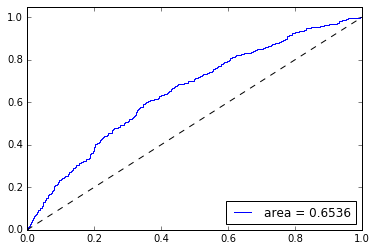

In [6]:
import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')
 
#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 10))
dev_data_numeric =  np.zeros((len(dev_data), 10))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set##############
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image
train_data_numeric[:,8] = train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))


#######process dev dataset#############
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) 
#Include Image
dev_data_numeric[:,8] =  dev_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))

#[:, [0,1,2,3,4,7,8, 9]]
###Start Logistic Regresson on numeric data
logit = LogisticRegression(C=1, penalty = 'l2')
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#How many positive case
print preds.sum()

#accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
#print "Accuracy = %0.4f" % (accuracy)
print result.coef_

model_output(pred_probas, F_Score, preds)

In [26]:
from datetime import date

# define functions for subsequent cell

def avgNumWords(post):
    sentences = [x.strip() for x in post.split('.')]
    num_words = len(post.split(' '))
    num_sentences = len([x.strip() for x in post.split('.')])

    return num_words / num_sentences

print avgNumWords("yo. i am here on the call. where are you?")

def monthsFrom2010(col):

    temp =  col.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d'))
    temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
    
    raop_create_date = datetime.datetime(2010, 12, 1)
    raop_create_date = raop_create_date.date()
    
    #print ("dates", temp[:5])
    #print (raop_create_date)

    temp = [x.date() for x in temp]
    # comment out days, and use months for better results
    #temp = [(x - raop_create_date).days for x in temp]
    temp = [((x - raop_create_date).days)/30 for x in temp]
    
    #print ("months", temp[:5])
    
    return temp


3


218
[[  1.09880554e-03   4.72461155e-04  -2.05569012e-02  -1.72850720e-01
   -3.75911608e-01   1.93116880e-05   2.30028084e-04  -1.14022670e-02
    6.51454600e-01   1.24658780e-01   3.71571333e-01   1.81120034e+00
    2.73524811e+00   3.09863963e-01   2.30693042e-01  -2.40228533e-02]]
Model F-Score = 0.5693 
Accuracy = 0.8331
precision_score: 0.857798
recall_score: 0.4260
roc_auc_score: 0.7007


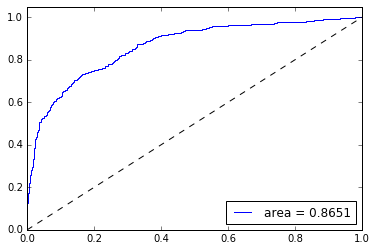

In [41]:
import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')

'''
print ("from_zone:", from_zone)
print ("to_zone:", to_zone)
print ("weekend:", weekend)
print ("cal:", to_zone)
print ("holidays:", holidays)
'''

#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 16))
dev_data_numeric =  np.zeros((len(dev_data), 16))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set###########################################################
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

'''
print ("ut:", ut[:5])
print ("temp:", temp[:5])
print ("utc:", utc[:5])
'''

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#train_data_numeric[:,8] = train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
train_data_numeric[:,8] = train_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))

train_data_numeric[:,10] = train_data['post_was_edited']==1
train_data_numeric[:,11] = train_data['request_number_of_comments_at_retrieval']>1
train_data_numeric[:,12] = train_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
train_data_numeric[:,13] = train_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3 #proxy num sentences
train_data_numeric[:,14] = train_data['request_text'].apply(lambda x: avgNumWords(x))>15 #proxy avg num words per sentence
train_data_numeric[:,15] = monthsFrom2010(train_data['unix_timestamp_of_request_utc']) #months from raop creation in 12/2010

#train_data_numeric[:,11] = train_data['requester_number_of_comments_in_raop_at_retrieval']>1
#train_data_numeric[:,12] = train_data['requester_number_of_posts_at_retrieval']>1

#######process dev dataset######################################################
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']>1
#Request during weekend
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) 
#Include Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#dev_data_numeric[:,8] =  dev_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,8] =  dev_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))

dev_data_numeric[:,10] = dev_data['post_was_edited']==1
dev_data_numeric[:,11] = dev_data['request_number_of_comments_at_retrieval']>1
dev_data_numeric[:,12] = dev_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
dev_data_numeric[:,13] = dev_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3  #proxy num sentences
dev_data_numeric[:,14] = dev_data['request_text'].apply(lambda x: avgNumWords(x))>15  #proxy avg num words per sentence
dev_data_numeric[:,15] = monthsFrom2010(dev_data['unix_timestamp_of_request_utc'])  #months from raop creation in 12/2010

#dev_data_numeric[:,11] = dev_data['requester_number_of_comments_in_raop_at_retrieval']>1
#dev_data_numeric[:,12] = dev_data['requester_number_of_posts_at_retrieval']>1

#[:, [0,1,2,3,4,7,8, 9]]
###Start Logistic Regresson on numeric data
logit = LogisticRegression(C=1, penalty = 'l2')
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#How many positive case
print preds.sum()
print result.coef_

model_output(pred_probas, F_Score, preds)

In [31]:
from scipy import sparse
from scipy.sparse import csr_matrix 
from scipy.sparse import coo_matrix, hstack
from bs4 import BeautifulSoup

def first_preprocessor(s):
    #convert to lowercase
    s=s.lower()
    s=re.sub("[,.!?:;/~*]"," ",s)
    #remove duplicated 0s and 1s
    s=re.sub("[0-9]*","",s)
    #remove number longer than 5 digit
    s=re.sub("[0-9]{5,}","",s)
    #remove stem end with 'ly'
    s=re.sub("ly\s"," ",s)
    #remove plural form
    s=re.sub("s\s"," ",s)
    s=re.sub("s\Z"," ",s)
    #remove _ as the end of word
    s=re.sub("[_]+"," ",s)
    #remove _ as start of the word
    s=re.sub("\s[_]+"," ",s)
    #remove stem end with 'ness'
    s=re.sub("ness\s"," ",s)
    s=re.sub("ing\s"," ",s)
    #remove words that are too short
    s=re.sub("\s[0-9a-z]{1,2}\s"," ",s)
    s=re.sub("\s[0-9a-z]{1,2}\Z"," ",s)
    s = BeautifulSoup(s).get_text() # Newly addition

    return s

def empty_preprocessor(s):
    return s


def tune_para(L1,L2):
    model_LG_L1 = LogisticRegression(penalty ='l1',C=L1)
    model_LG_L1.fit(word_matrix_process, train_labels)

    index=[]
    for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
        if z!=0:
            index.append(i)

    model_LG_L2 = LogisticRegression(penalty ='l2',C=L2 )
    model_LG_L2.fit(word_matrix_process[:,index], train_labels)
    
    f1_score=metrics.f1_score(dev_labels,model_LG_L2.predict(dev_matrix_process[:,index]),average='binary')
    
    return f1_score


In [11]:
print train_data.loc[0,'requester_upvotes_minus_downvotes_at_retrieval']
c = 0
for i in list(train_data):
    c = c +1
    print i
print len(list(train_data))

212
giver_username_if_known
in_test_set
number_of_downvotes_of_request_at_retrieval
number_of_upvotes_of_request_at_retrieval
post_was_edited
request_id
request_number_of_comments_at_retrieval
request_text
request_text_edit_aware
request_title
requester_account_age_in_days_at_request
requester_account_age_in_days_at_retrieval
requester_days_since_first_post_on_raop_at_request
requester_days_since_first_post_on_raop_at_retrieval
requester_number_of_comments_at_request
requester_number_of_comments_at_retrieval
requester_number_of_comments_in_raop_at_request
requester_number_of_comments_in_raop_at_retrieval
requester_number_of_posts_at_request
requester_number_of_posts_at_retrieval
requester_number_of_posts_on_raop_at_request
requester_number_of_posts_on_raop_at_retrieval
requester_number_of_subreddits_at_request
requester_subreddits_at_request
requester_upvotes_minus_downvotes_at_request
requester_upvotes_minus_downvotes_at_retrieval
requester_upvotes_plus_downvotes_at_request
requester_

# Text Analysis

In [32]:
train_text=train_data['request_text'].as_matrix()
train_title=train_data['request_title'].as_matrix()
train_all = train_text+train_title

dev_text=dev_data['request_text'].as_matrix()
dev_title=dev_data['request_title'].as_matrix()
dev_all = dev_text+dev_title


###1)Baseline: no reprocess, no feature selection

In [267]:
def empty_preprocessor(s):
    return s


vectorizer_process = CountVectorizer(preprocessor =empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)


model_LG = LogisticRegression(penalty ='l2',C=12)
model_LG.fit(word_matrix_process, train_labels)

print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG.predict(dev_matrix_process),average='binary'))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG.predict(dev_matrix_process)))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG.predict(dev_matrix_process)))

f1_score: 0.301158
precision_score: 0.346154
recall_score: 0.266515


###2)Add preprocessing and L1 feature selection

===>>Add Preprocessing

In [4]:
#Roc curve:
from sklearn.metrics import roc_curve, auc

def model_output(pred_probas, F_Score, preds):

    print ("Model F-Score = %0.4f "%(F_Score))  #Sum up Squared Weights
    accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
    print ("Accuracy = %0.4f"    % (accuracy))
    print ('precision_score: %f'  % metrics.precision_score(dev_labels, preds))
    print ('recall_score: %0.4f' % metrics.recall_score(dev_labels, preds))
    print ('roc_auc_score: %0.4f'% metrics.roc_auc_score(dev_labels, preds))

#Create ROC Curve

    fpr,tpr,_ = roc_curve(dev_labels, pred_probas[:,1])
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label='area = %.4f' %roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.legend(loc='lower right')

In [25]:
# train_data_array=train_data['request_text'].as_matrix()
vectorizer_process = CountVectorizer(preprocessor = first_preprocessor,analyzer='word',stop_words='english', tokenizer=tokenize)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

max=0
l1=0
l2=0
for i in range(500,600,10):
    for j in range(1,50,2):
        acc=tune_para(i,j)
        if acc>max:
            max=acc
            l1=i
            l2=j
print('When l1=%i ,l2=%i , f1 score is %f' %(l1,l2,max))

When l1=580 ,l2=47 , f1 score is 0.336075


# Random Forest

Number of positive predictions: 211
Model F-Score = 0.5662 
Accuracy = 0.8337
precision_score: 0.872038
recall_score: 0.4191
roc_auc_score: 0.6988


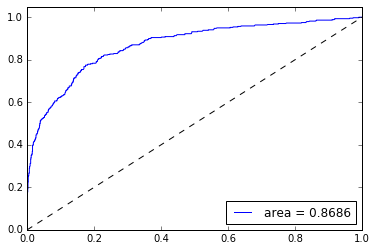

In [46]:
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

# Create the random forest object which will include all the parameters
forest = RandomForestClassifier(n_estimators = 7000)

# Fit RandomForest
forest = forest.fit(all_data_train, train_labels)

all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

# Take the same decision trees and run it on the test data
preds = forest.predict(all_data_dev)

#preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = forest.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

Number of positive predictions: 182
Model F-Score = 0.5217 
Accuracy = 0.8249
precision_score: 0.890110
recall_score: 0.3690
roc_auc_score: 0.6766


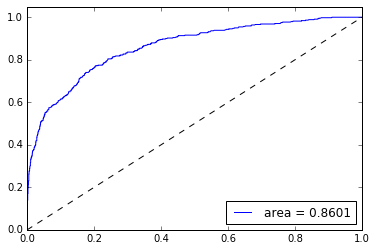

In [50]:
#Big Model II: Run L1 after combine

# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

all_data_train = np.append(word_matrix_process.toarray(), train_data_numeric, 1)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.01)#C from the above test
model_LG_L1.fit(all_data_train, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

#all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

# Create the random forest object which will include all the parameters
forest = RandomForestClassifier(n_estimators = 7000)

# Fit RandomForest
forest = forest.fit(all_data_train[:,index], train_labels)

all_data_dev = np.append(dev_matrix_process.toarray(), dev_data_numeric, 1)

# Take the same decision trees and run it on the test data
preds = forest.predict(all_data_dev[:,index])

#preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = forest.predict_proba(all_data_dev[:,index])

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

#Best Model so far:

Number of positive predictions: 242
Model F-Score = 0.5962 
Accuracy = 0.8379
precision_score: 0.838843
recall_score: 0.4624
roc_auc_score: 0.7157


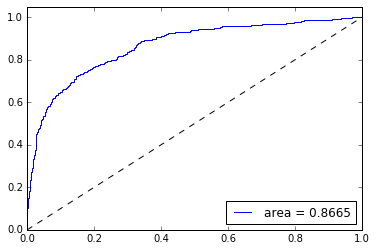

In [51]:
#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.01)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)

model_LG = LogisticRegression(penalty ='l2',C=0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)

all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

LG_preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, LG_preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(LG_preds))
#Call to display outputs
model_output(pred_probas, F_Score, LG_preds) #Please input pred_probas, F_Score, and prediction(preds)

Number of positive predictions: 234
Model F-Score = 0.5944 
Accuracy = 0.8390
precision_score: 0.854701
recall_score: 0.4556
roc_auc_score: 0.7143


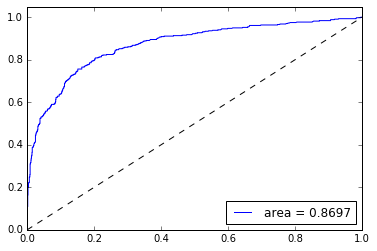

In [114]:
#Basic Ensemble
#Best Model
# Import the random forest package
from sklearn.ensemble import RandomForestClassifier 

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
all_data_train = 0
all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)
all_data_train = np.insert(all_data_train, all_data_train.shape[1], LG_t[:,1], axis=1)  #LG output
#all_data_train = np.insert(all_data_train, all_data_train.shape[1], NB_t[:,1], axis=1)

# Create the random forest object which will include all the parameters
forest = RandomForestClassifier(n_estimators = 10000)

# Fit the training data to the Survived labels and create the decision trees
forest = forest.fit(all_data_train, train_labels)

all_data_dev = 0
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)
all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], LG_d[:,1], axis=1)
#all_data_dev = np.insert(all_data_dev, all_data_dev.shape[1], NB_d[:,1], axis=1)

# Take the same decision trees and run it on the test data
preds = forest.predict(all_data_dev)

#preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = forest.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

In [111]:
print 'nano'

nano


In [112]:
#Ensemble Input one
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.01)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

all_data_train = 0
all_data_dev = 0

all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)


model_LG = LogisticRegression(penalty ='l2',C=0.1)#C from the above test
model_LG.fit(all_data_train, train_labels)
all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

LG_t = model_LG.predict_proba(all_data_train)
LG_d = model_LG.predict_proba(all_data_dev)

print 'nano'

nano


#Adding Naive Bayes Does not Help overall performance
#Best model currently is Ensemble of LG + randomforest

Number of positive predictions: 1646
Model F-Score = 0.4201 
Accuracy = 0.2871
precision_score: 0.266100
recall_score: 0.9977
roc_auc_score: 0.5184


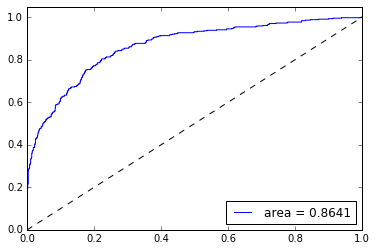

In [106]:
#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.008)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
        
bdt = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                         algorithm="SAMME",
                         n_estimators=10000)

all_data_train = np.append(word_matrix_process[:,index].toarray(), train_data_numeric, 1)
# Fit AdaBoost
ada = bdt.fit(all_data_train, train_labels)

all_data_dev = np.append(dev_matrix_process[:,index].toarray(), dev_data_numeric, 1)

# Take the same decision trees and run it on the test data
preds = ada.predict(all_data_dev)

#preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = ada.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)

Number of positive predictions: 289
Model F-Score = 0.3516 
Accuracy = 0.7217
precision_score: 0.442907
recall_score: 0.2916
roc_auc_score: 0.5817


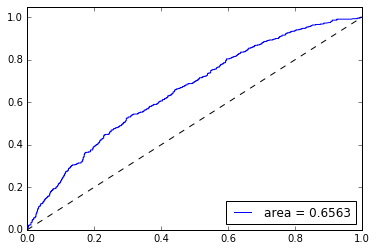

In [89]:
#Naive Bayes
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

bnb = BernoulliNB(alpha=0.001, binarize=0.5)
bnb.fit(word_matrix_process[:,index].toarray(), train_labels)
NB_t = bnb.predict_proba(word_matrix_process[:,index].toarray())
NB_d = bnb.predict_proba(dev_matrix_process[:,index].toarray())
#Update the new index
# Take the same decision trees and run it on the test data
preds = bnb.predict(dev_matrix_process[:,index].toarray())

#preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = bnb.predict_proba(dev_matrix_process[:,index].toarray())

print "Number of positive predictions: %d" % (sum(preds))
#Call to display outputs
model_output(pred_probas, F_Score, preds)

Number of positive predictions: 280
Model F-Score = 0.4757 
Accuracy = 0.7777
precision_score: 0.610714
recall_score: 0.3895
roc_auc_score: 0.6514


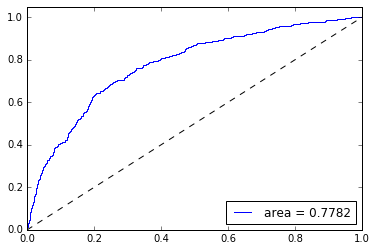

In [80]:
#LG numeric + RF_text ensemble
from sklearn.ensemble import RandomForestClassifier 
#Best non-ensemble method so far
np.random.seed(0)

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=0.1)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)

word_matrix_process[:,index].toarray()

# Create the random forest object which will include all the parameters
forest = RandomForestClassifier(n_estimators = 7000)

# Fit RandomForest
forest = forest.fit(word_matrix_process[:,index].toarray(), train_labels)

RF_t = forest.predict_proba(word_matrix_process[:,index].toarray())
RF_d = forest.predict_proba(dev_matrix_process[:,index].toarray())
########################################################################
########################################Training LG models#############

all_data_train = np.insert(train_data_numeric, train_data_numeric.shape[1], RF_t[:,1], axis=1)
all_data_dev   = np.insert(dev_data_numeric, dev_data_numeric.shape[1], RF_d[:,1], axis=1)

model_LG = LogisticRegression(penalty ='l2',C=1)#C from the above test
model_LG.fit(all_data_train, train_labels)

LG_preds = model_LG.predict(all_data_dev)
F_Score = metrics.f1_score(dev_labels, LG_preds, average='binary')
pred_probas = model_LG.predict_proba(all_data_dev)

print "Number of positive predictions: %d" % (sum(LG_preds))
#Call to display outputs
model_output(pred_probas, F_Score, LG_preds) #Please input pred_probas, F_Score, and prediction(preds)

In [332]:
all_data = np.append(word_matrix_process.toarray(), train_data_numeric, 1)
print all_data_train.shape[1]
print all_data.shape
b = np.array(LG_t)
print b.shape
#print LG_d.shape
#np.concatenate((my_data, new_col), 1)
a = np.insert(all_data, 11018, LG_t, axis=1)
#a = np.concatenate((all_data, b.T), axis = 1)
print a.shape

3975
(3975, 11018)
(3975,)
(3975, 11019)


In [ ]:
#Basic Ensemble Method:
np.random.seed(0)
vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)


model_LG_L1 = LogisticRegression(penalty ='l1',C=510)#C from the above test
model_LG_L1.fit(word_matrix_process.toarray(), train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
all_data = np.append(word_matrix_process[:,index], train_data_numeric, 1)
model_LG = LogisticRegression(penalty ='l2',C=11)#C from the above test


model_LG.fit(word_matrix_process[:,index], train_labels)


preds = model_LG.predict(dev_matrix_process[:,index])
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = model_LG.predict_proba(dev_matrix_process[:,index])


#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)


<type 'numpy.ndarray'>
394
Model F-Score = 0.3289 
Accuracy = 0.6704
precision_score: 0.347716
recall_score: 0.3121
roc_auc_score: 0.5538


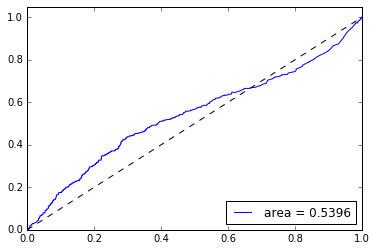

In [276]:
#Basic Ensemble Method:
np.random.seed(0)
vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

print type(word_matrix_process.toarray())

model_LG_L1 = LogisticRegression(penalty ='l1',C=510)#C from the above test
model_LG_L1.fit(word_matrix_process.toarray(), train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=11)#C from the above test
model_LG.fit(word_matrix_process[:,index], train_labels)


#######Ensemble Method Starts###################################
logit = LogisticRegression()
logit_en = LogisticRegression()
logit.fit(train_data_numeric[:,:], train_labels)

#Create a new set of step 2 logistic regression based on step 1 probability outputs
#X1: predicted prob. of positive labels with text-based model
#X2: predicted prob. of positive labels with text-based model
En_X1_train = logit.predict_proba(train_data_numeric[:,:])[:,1]
En_X2_train = model_LG.predict_proba(word_matrix_process[:,index])[:,1]
En_X1_dev = logit.predict_proba(dev_data_numeric[:,:])[:,1]
En_X2_dev = model_LG.predict_proba(dev_matrix_process[:,index])[:,1]

t_size = len(En_X1_train)
d_size = len(En_X1_dev)
En_train = np.zeros((t_size, 2))
En_dev = np.zeros((d_size, 2))

En_train[:,0] = np.round(En_X1_train, 2)
En_train[:,1] = np.round(En_X2_train, 2)
En_dev[:,0] =   np.round(En_X1_dev, 2)
En_dev[:,1] =   np.round(En_X2_dev, 2)

logit_en.fit(En_train, train_labels)

preds = logit_en.predict(En_dev)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit_en.predict_proba(En_dev)

print preds.sum()

#Call to display outputs
model_output(pred_probas, F_Score, preds) #Please input pred_probas, F_Score, and prediction(preds)


###3)NLTK

In [35]:
import nltk
import string
import os

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
path = '/opt/datacourse/data/parts'
token_dict = {}
stemmer = SnowballStemmer("english", ignore_stopwords=True)

def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems

vectorizer_process = CountVectorizer(analyzer='word',stop_words='english',preprocessor = first_preprocessor,tokenizer=tokenize)
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=580)#C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

#Update the new index
index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)
            
model_LG = LogisticRegression(penalty ='l2',C=47)#C from the above test
model_LG.fit(word_matrix_process[:,index], train_labels)

preds = model_LG.predict(dev_matrix_process[:,index])
F_Score = metrics.f1_score(dev_labels, preds, average='binary')


print "Logistic regression on numeric data: F-Score = %0.4f: "%(F_Score)  #Sum up Squared Weights
accuracy = np.where(preds==dev_labels, 1, 0).sum() / float(len(dev_labels))
print ("Accuracy = %0.4f" % (accuracy))
print 'accuracy_score: %f' %metrics.precision_score(dev_labels, preds)
print 'recall_score: %f' %metrics.recall_score(dev_labels, preds)
print "roc_auc_score:", metrics.roc_auc_score(dev_labels, preds)

Logistic regression on numeric data: F-Score = 0.3224: 
Accuracy = 0.6604
accuracy_score: 0.333333
recall_score: 0.312073
roc_auc_score: 0.547046788554


('dates', 0   2012-07-06
2   2011-07-02
3   2011-08-22
4   2013-04-24
5   2013-02-25
Name: unix_timestamp_of_request_utc, dtype: datetime64[ns])
('months', [19, 7, 8, 29, 27])
('dates', 1    2012-03-15
7    2012-05-15
8    2012-11-06
10   2011-08-02
13   2011-06-29
Name: unix_timestamp_of_request_utc, dtype: datetime64[ns])
('months', [15, 17, 23, 8, 7])
192
[[  5.85999578e-03   6.33915043e-04   4.21054771e-03  -1.25148019e-01
   -3.21774527e-01   1.65036704e-05   6.29830755e-04   2.17077756e-02
    5.22745828e-01   3.05107899e-01   4.53967835e-01   1.81963336e+00
    2.79980864e+00   4.35645686e-01   3.05886106e-01  -8.86487693e-03]]
Model F-Score = 0.5293 
Accuracy = 0.8249
precision_score: 0.869792
recall_score: 0.3804
roc_auc_score: 0.6803


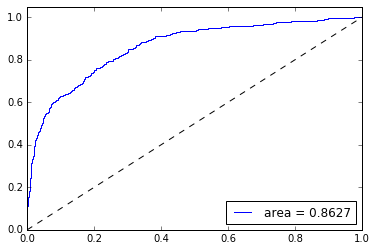

In [15]:
import datetime
from pytz import timezone
from dateutil import tz
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
np.random.seed(0)

#Setting up logic to identify timezone, weekend, and holidays
from_zone = tz.gettz('UTC')
to_zone = tz.gettz('America/Chicago')
weekend = set([5, 6])
cal = calendar()
holidays = cal.holidays(start='2011-04-07', end='2013-10-11')

#Created new df for training data(numeric only)
train_data_numeric = np.zeros((len(train_data), 16))
dev_data_numeric =  np.zeros((len(dev_data), 16))

find_image = re.compile(r'(imgur\.com|\.jpg)')  #compile this to combine with other function

#####Process train data set###########################################################
ut = train_data['unix_timestamp_of_request_utc']
temp =  ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp =  temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =   temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])
    
train_data_numeric[:,0] = train_data['request_title'].apply(lambda x: len(x.split(' ')))  #Title length
train_data_numeric[:,1] = train_data['request_text'].apply(lambda x: len(x.split(' ')))   #Text length
train_data_numeric[:,2] = temp['T'].dt.month      #Month in integer
train_data_numeric[:,3] = temp['T'].dt.day > 15   #2nd 1/2 month
train_data_numeric[:,4] = temp['T'].dt.hour > 12  #Passed noon
train_data_numeric[:,5] = train_data['requester_upvotes_minus_downvotes_at_retrieval']
train_data_numeric[:,6] = train_data['requester_account_age_in_days_at_retrieval']
#Request during weekend
train_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend)
#Has Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#train_data_numeric[:,8] = train_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
train_data_numeric[:,8] = train_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
#Requested date a holiday
train_data_numeric[:,9] = (train_data['unix_timestamp_of_request_utc']
                           .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                           .apply(lambda x: 1 if x in holidays else 0))

train_data_numeric[:,10] = train_data['post_was_edited']==1
train_data_numeric[:,11] = train_data['request_number_of_comments_at_retrieval']>1
train_data_numeric[:,12] = train_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
train_data_numeric[:,13] = train_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3 #proxy num sentences
train_data_numeric[:,14] = train_data['request_text'].apply(lambda x: avgNumWords(x))>15 #proxy avg num words per sentence
train_data_numeric[:,15] = monthsFrom2010(train_data['unix_timestamp_of_request_utc']) #months from raop creation in 12/2010

#######process dev dataset######################################################
ut = dev_data['unix_timestamp_of_request_utc']
temp = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))
temp = temp.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
utc =  temp.apply(lambda x: x.replace(tzinfo=from_zone))

temp = [] 
for i in utc:
    temp.append(i.astimezone(to_zone))
temp = pd.DataFrame(temp, columns=["T"])

dev_data_numeric[:,0] = dev_data['request_title'].apply(lambda x: len(x.split(' '))) 
dev_data_numeric[:,1] = dev_data['request_text'].apply(lambda x: len(x.split(' ')))
dev_data_numeric[:,2] = temp['T'].dt.month
dev_data_numeric[:,3] = temp['T'].dt.day > 15
dev_data_numeric[:,4] = temp['T'].dt.hour > 12 
dev_data_numeric[:,5] = dev_data['requester_upvotes_minus_downvotes_at_retrieval']
dev_data_numeric[:,6] = dev_data['requester_account_age_in_days_at_retrieval']>1
#Request during weekend
dev_data_numeric[:,7] = ut.apply(lambda x: datetime.datetime.fromtimestamp(x).weekday() in weekend) 
#Include Image
#experiment with request_text over request_text_edit_aware, and use post_was_edited below it
#dev_data_numeric[:,8] =  dev_data['request_text_edit_aware'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,8] =  dev_data['request_text'].apply(lambda x: 1 if find_image.findall(x) else 0 )
dev_data_numeric[:,9] = (dev_data['unix_timestamp_of_request_utc']
                         .apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d')) 
                         .apply(lambda x: 1 if x in holidays else 0))

dev_data_numeric[:,10] = dev_data['post_was_edited']==1
dev_data_numeric[:,11] = dev_data['request_number_of_comments_at_retrieval']>1
dev_data_numeric[:,12] = dev_data['requester_number_of_posts_on_raop_at_retrieval']>1
# dont split on ; or ?, as it lowers the result
dev_data_numeric[:,13] = dev_data['request_text'].apply(lambda x: len(re.split(r'[.]',x)))>3  #proxy num sentences
dev_data_numeric[:,14] = dev_data['request_text'].apply(lambda x: avgNumWords(x))>15  #proxy avg num words per sentence
dev_data_numeric[:,15] = monthsFrom2010(dev_data['unix_timestamp_of_request_utc'])  #months from raop creation in 12/2010

#dev_data_numeric[:,11] = dev_data['requester_number_of_comments_in_raop_at_retrieval']>1
#dev_data_numeric[:,12] = dev_data['requester_number_of_posts_at_retrieval']>1

#[:, [0,1,2,3,4,7,8, 9]]
###Start Logistic Regresson on numeric data
logit = LogisticRegression(C=1, penalty = 'l2')
result = logit.fit(train_data_numeric, train_labels)

preds = logit.predict(dev_data_numeric)
F_Score = metrics.f1_score(dev_labels, preds, average='binary')
pred_probas = logit.predict_proba(dev_data_numeric)

#How many positive case
print preds.sum()
print result.coef_

model_output(pred_probas, F_Score, preds)

###4)PCA

In [ ]:
#get a list of features based on the L1 regularization, instead of inputting all words into PCA to improve the speed
vectorizer_process = CountVectorizer(preprocessor = empty_preprocessor,analyzer='word',stop_words='english' )
word_matrix_process= vectorizer_process.fit_transform(train_all)
dev_matrix_process = vectorizer_process.transform(dev_all)

model_LG_L1 = LogisticRegression(penalty ='l1',C=560) #C from the above test
model_LG_L1.fit(word_matrix_process, train_labels)

index=[]
for i,z in enumerate(np.sum(np.abs(model_LG_L1.coef_),axis=0) ):
    if z!=0:
        index.append(i)


In [ ]:
from sklearn.decomposition import PCA

i=1000
pca_mod = PCA(n_components = i)
word_matrix_process_pca=pca_mod.fit_transform(word_matrix_process.toarray()[:,index])
print('For the first %i element, %f of the total variance in the training data is explained ' %(i,sum(pca_mod.explained_variance_ratio_)) )
plt.plot(pca_mod.explained_variance_ratio_)

In [47]:
dev_matrix_process_pca=pca_mod.transform(dev_matrix_process.toarray()[:,index])

model_LG_L2 = LogisticRegression(penalty ='l2',C=19 )#C from the above test
model_LG_L2.fit(word_matrix_process_pca, train_labels)

print('f1_score: %f' %metrics.f1_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca),average='binary'))
print('recall_score: %f' %metrics.recall_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca)))
print('precision_score: %f' %metrics.precision_score(dev_labels,model_LG_L2.predict(dev_matrix_process_pca)))

f1_score: 0.316069
recall_score: 0.271071
precision_score: 0.378981
